# Covid-19 Averse Vaccine Response Prediction
![vaccine brands](../data/images/vaccines.jpg)
Author: Christos Maglaras<br>
Date : 4/14/2021
## Stakeholder
This project is mainly focused on serving the induvidual by providing an prediction based on personal information of the possibility of a negative reaction from one of the Covid-19 vaccines. It could also be applied in a medical center such as a clinic or hospital to screen patients easily and quickly. If you would like to know your or anothers risk of illness from one of the three available vaccines you may enter some or all of your personal information into the following web form ~flask link~. Successfully being able to predict the outcome of a patient utilizing nothing more than an online form would be higly beneficial to the patient of course, but also the healthcare system by decreasing the amount of strain placed on hospitals. 

## Data
The data utilized for this project has been sourced from the CDC VAERS system, a public dataset consisting of thirty years of domestic adverse vaccine events. Medical professionals and vaccine manufactures are required to report all adverse reactions that come to their attention. While they are required to submit records, anyone can submit a report of their experience. The data consists of general informations such as age and sex, vaccination information like the administration facility and brand, and health information such as preexisting illnesses, allergies, and medications they may take. This dataset contains roughly 70,000 records containing covid-19 vaccines, and is updated every two weeks with new records. You can collect the data [Here](https://vaers.hhs.gov/data/datasets.html?).
![vaers](../data/images/vaers.png)

## Business Understanding
This system would alleviate some of the pressure from hospitals, freeing up resources so they can operate more effectively. The first way in which a system like this would help is as a first step screening method, filtering patients to at least notify their clinician of their risks. The second is that in avoiding the adverse reactions, the hospitals do not need to dedicate extra resources to the patient after the reaction. Aulthough we have here seventy thousand cases reporting adverse reactions, the US now has reached five million vaccinations of at least one dose, and three million full vaccinations, meaning that these adverse reactions are only 1.4% of all domestic vaccinations. This is not to say that the 1.4% are to be ignored, with the legal age of the vaccine being sixteen, that leaves two hundred thirty million people eligible for the vaccine in the us, 1.4% being three million.

## Model
The model that achieved the best results was xgboost optimized using the Bayesian Optimization technique. This achieved significantly better results than both the standard random forests and the neural network which were not able to produce informative models. Aulthough there is some difficulty differentiating between hospital-bound and those who are not, that is between patients who all had some sort of averse reaction. A real wold test might be more precice as it has been trained on the more difficult task of seperating two groups who are very similar to one another. 

## Contents
```
├── data
|   ├── vaers_guide.pdf
|   ├── images
|   |   ├── vaccines.jpg
|   |   └── vaers.mp4
|   └── dataset
|       ├── 2020
|       |   ├── data20.csv
|       |   ├── symptoms20.csv
|       |   └── vax20.csv
|       └── 2021
|           ├── data21.csv
|           ├── symptoms21.csv
|           └── vax21.csv
├── notebooks
|   ├── Exploration Notebook.ipynb
|   ├── Final Notebook.ipynb
|   └── MVP Final Notebook.ipynb
├── presentation.pdf
└── README.md
```
# Data Preprocessing

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report,mean_squared_error, roc_auc_score, make_scorer
from sklearn.metrics import recall_score

import lazypredict
# from lazypredict.Supervised import LazyClassifier

import xgboost as xgb
from bayes_opt import BayesianOptimization

# import tensorflow as tf
# from tensorflow.keras.layers import Dense, Dropout

pd.set_option('display.max_columns', None)
import warnings; warnings.simplefilter('ignore')

In [13]:
# lets load all three datasets for each year with relavant vaccinations
symptoms20 = pd.read_csv('../data/2020/symptoms20.csv', index_col=['VAERS_ID'], encoding='latin-1')
data20     = pd.read_csv('../data/2020/data20.csv', index_col=['VAERS_ID'], encoding='latin-1')
vax20      = pd.read_csv('../data/2020/vax20.csv', index_col=['VAERS_ID'], encoding='latin-1')

symptoms21 = pd.read_csv('../data/2021/symptoms21.csv', index_col=['VAERS_ID'], encoding='latin-1')
data21     = pd.read_csv('../data/2021/data21.csv', index_col=['VAERS_ID'], encoding='latin-1')
vax21      = pd.read_csv('../data/2021/vax21.csv', index_col=['VAERS_ID'], encoding='latin-1')

In [14]:
combined_vax = pd.concat([vax20, vax21])
combined_data = pd.concat([data20, data21])
combined_symptoms = pd.concat([symptoms20, symptoms21])

In [15]:
datavax = pd.merge(combined_data, combined_vax, on='VAERS_ID', how='right')
dvs = pd.merge(datavax, combined_symptoms, on='VAERS_ID', how='left')

In [16]:
df = dvs[dvs['VAX_TYPE'] == 'COVID19']

In [17]:
df.drop_duplicates(inplace=True)

In [18]:
df['DIED'] = df['DIED'].fillna(0)
df['DIED'] = df['DIED'].replace('Y', 1)

df['SEX'] = df['SEX'].replace('U', '0')
df['SEX'] = df['SEX'].replace('F', '0')
df['SEX'] = df['SEX'].replace('M', '1')

df['L_THREAT'] = df['L_THREAT'].fillna(0)
df['L_THREAT'] = df['L_THREAT'].replace('Y', 1)

df['HOSPITAL'] = df['HOSPITAL'].fillna(0)
df['HOSPITAL'] = df['HOSPITAL'].replace('Y', 1)

df['HOSPDAYS'] = df['HOSPDAYS'].fillna(0)

df['X_STAY'] = df['X_STAY'].fillna(0)
df['X_STAY'] = df['X_STAY'].replace('Y', 1)

df['DISABLE'] = df['DISABLE'].fillna(0)
df['DISABLE'] = df['DISABLE'].replace('Y', 1)

df['RECOVD'] = df['RECOVD'].fillna(0)
df['RECOVD'] = df['RECOVD'].replace('U', 0)
df['RECOVD'] = df['RECOVD'].replace('N', 0)
df['RECOVD'] = df['RECOVD'].replace('Y', 1)

df['BIRTH_DEFECT'] = df['BIRTH_DEFECT'].fillna(0)
df['BIRTH_DEFECT'] = df['BIRTH_DEFECT'].replace('Y', 1)

df['VAX_DOSE_SERIES'] = df['VAX_DOSE_SERIES'].fillna(0)
df['VAX_DOSE_SERIES'] = df['VAX_DOSE_SERIES'].replace('7+', 7)
df['VAX_DOSE_SERIES'] = df['VAX_DOSE_SERIES'].replace('UNK', 1)

df['NUMDAYS'] = df['NUMDAYS'].where(df['NUMDAYS']<120, 7)

In [19]:
df['SEX'] = df['SEX'].astype(int)
df['AGE_YRS'] = df['AGE_YRS'].fillna(50)
df['AGE_YRS'] = df['AGE_YRS'].astype(int)
df['HOSPDAYS'] = df['HOSPDAYS'].astype(int)
df['NUMDAYS'] = df['NUMDAYS'].astype(int)
df['VAX_DOSE_SERIES'] = df['VAX_DOSE_SERIES'].astype(int)

# Data Processing
### State

In [20]:
# lets clean up the state column by filling NaN values and binning the unusual locations as Other as there are only a few of each
df['STATE'].replace(['AS', 'VI', 'MP', 'Ca', 'XB', 'FM', 'MH', 'GU'], 'OTH', inplace=True)
df['STATE'] = df['STATE'].fillna('NA')

label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(df['STATE'])
df['STATE'] = label_encoder.transform(df['STATE'])

### Vaccine Manufacturer

In [21]:
# since there are no NaNs or unwanted values we can just fit and transform
df['VAX_MANU'].value_counts()

label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(df['VAX_MANU'])
df['VAX_MANU'] = label_encoder.transform(df['VAX_MANU'])

### Injection Site

In [22]:
# where the dose was applied, right arm, left arm, leg, ect.
df['VAX_SITE'] = df['VAX_SITE'].fillna('NA')

label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(df['VAX_SITE'])
df['VAX_SITE'] = label_encoder.transform(df['VAX_SITE'])

### Delivery Method

In [23]:
# states the method of delivering the vaccine, such as srynge, nasal, intradermal, intramuscular, and others
df['VAX_ROUTE'] = df['VAX_ROUTE'].fillna('UN')

label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(df['VAX_ROUTE'])
df['VAX_ROUTE'] = label_encoder.transform(df['VAX_ROUTE'])

### Administration Facility

In [24]:
# examples of locations would be school, military, senior home ect.
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(df['V_ADMINBY'])
df['V_ADMINBY'] = label_encoder.transform(df['V_ADMINBY'])

### Allergies

In [25]:
# the following columns cleaned cannot using LabelEncoder as many rows have multiple values to represent.

In [26]:
# preparing the columns with text data is a little tricky as there is no standard format, many misspellings, and multiple values presented for many people
# Lets begin by lowercasing the Allergies column
df['ALLERGIES'] = df['ALLERGIES'].str.lower()

In [27]:
# Now we replace all these different ways of saying none with none, as well as NaNs
nonelist = ['no', 'no known allergies', 'unknown', 'none known', 'n/a', 'none reported', 'na', 'none.',
            'no known drug allergies', 'no allergies', 'na', 'no known', 'no known allergies.', 'none listed', 
           'unk', 'none known.']

df['ALLERGIES'] = df['ALLERGIES'].fillna('none')
df['ALLERGIES'] = df['ALLERGIES'].replace('penicillin|sulfa', 'penicillin')
df['ALLERGIES'] = df['ALLERGIES'].replace(nonelist, 'none')

In [28]:
# these functions will find each list-like text and turn it into a format acceptable for get_dummies
# We are using this method instead of onehotencoder or labelbinarizer so a row can have multiple allergies represented
# by only using the allergies that at least thirty people have in the data, we can keep the dimensionality and required cleaning down
# it is likely that an algorith would not be able to learn from allergies that have a very small representation
allall = []
for each in df['ALLERGIES']:
    if ',' in each:
        alls = each.split(',')
        ally = []
        for weach in alls:
            ally.append(weach.strip())
        allall.append(ally)
    else:
        allall.append(each)
        
allall2 = []
for each in allall:
    if type(each) == list:
        welt = "|".join(each)
        allall2.append(welt)
    else:
        allall2.append(each)
        
listy = list(pd.Series(allall2).value_counts()[pd.Series(allall2).value_counts()>30].index)
allall3 = list(map(lambda x: 'none' if x not in listy else x, allall2))

dummyframe = pd.Series(allall3).str.get_dummies()

listy.remove('penicillin|sulfa')

In [29]:
df.reset_index(inplace=True)

In [30]:
# Lets attach our new columns to the dataframe
df = df.join(dummyframe[listy])

### Current Illnesses

In [31]:
df['CUR_ILL'] = df['CUR_ILL'].str.lower()

nonelist = ['no', 'unknown', 'none.', 'none reported', 'n/a', 'na', 'none known', 'denies', 'none noted', '0', 'no illness',
           'none listed', 'not known', 'no known', 'non', 'no acute illnesses', 'no.', 'denied', 'see below', 'no illnesses',
            'unk', 'unkown', 'none documented', 'none stated', 'nothing', 'none known.', 'unknown.', 'no known illnesses',
            'n/a.','no e', 'none reported.', 'no acute illness']

df['CUR_ILL'] = df['CUR_ILL'].fillna('none')
df['CUR_ILL'] = df['CUR_ILL'].replace(nonelist, 'none')
df['CUR_ILL'] = df['CUR_ILL'].replace(['covid 19', 'covid', 'covid- 19 diagnosis 12/11/2020 asymptomatic', 'covid-19 (diagnosed 10/26/20)', 'covid-19  (diagnosed 10/26/20)'], 'covid-19')

In [32]:
allall = []
for each in df['CUR_ILL']:
    if ',' in each:
        alls = each.split(',')
        ally = []
        for weach in alls:
            ally.append(weach.strip())
        allall.append(ally)
    else:
        allall.append(each)
        
allall2 = []
for each in allall:
    if type(each) == list:
        welt = "|".join(each)
        allall2.append(welt)
    else:
        allall2.append(each)
        
listy = list(pd.Series(allall2).value_counts()[pd.Series(allall2).value_counts()>13].index)
allall3 = list(map(lambda x: 'none' if x not in listy else x, allall2))
    
datufrayme = pd.Series(allall3).str.get_dummies()

listy.remove('alcohol use disorder|facial laceration|alcohol intoxication|secondary syphillis')
listy.remove('elevated troponin i level elevated troponin i level        elevated brain natriuretic peptide (bnp) level elevated brain natriuretic peptide (bnp) level        dyspnea       chest pain        atrial fibrillation with rapid ventricular response (hcc) atrial fibrillation with rapid ventricular response|initial encounter       hyponatremia hyponatremia')
    
df = df.join(datufrayme[listy], lsuffix=" cur_ill")

### Patient History

In [33]:
df['HISTORY'] = df['HISTORY'].str.lower()

In [34]:
# Quite a few entries for history need to be rectified, doubles were found using .value_counts() as we use the most common
nonelist = ['no', 'unknown', 'none.', 'none reported', 'n/a', 'na', 'none known', 'denies', 'none noted', '0', 'no illness',
           'none listed', 'not known', 'no known', 'non', 'no acute illnesses', 'no.', 'denied', 'see below', 'no illnesses',
            'unk', 'unkown', 'none documented', 'none stated', 'nothing', 'none known.', 'unknown.', 'as above', 'no known illnesses',
            'n/a.','no e', 'none reported.', 'medical history/concurrent conditions: no adverse event (no reported medical history)',
           'medical history/concurrent conditions: no adverse event (no reported medical history.)', 'see above', 'medical history/concurrent conditions: no adverse event',
           'medical history/concurrent conditions: no adverse event (no medical history reported.)', 'medical history/concurrent conditions: no adverse event (no medical history reported)',
           'medical history/concurrent conditions: no adverse event (medical history not provided)', 'comments: list of non-encoded patient relevant history: patient other relevant history 1: none',
           ]

df['HISTORY'] = df['HISTORY'].fillna('none')
df['HISTORY'] = df['HISTORY'].replace(nonelist, 'none')
df['HISTORY'] = df['HISTORY'].replace('medical history/concurrent conditions: covid-19', 'covid-19')
df['HISTORY'] = df['HISTORY'].replace('medical history/concurrent conditions: hypertension', 'hypertension')
df['HISTORY'] = df['HISTORY'].replace('medical history/concurrent conditions: penicillin allergy', 'penicillin allergy')
df['HISTORY'] = df['HISTORY'].replace(['medical history/concurrent conditions: asthma','mild asthma','exercise induced asthma'], 'asthma')
df['HISTORY'] = df['HISTORY'].replace('medical history/concurrent conditions: blood pressure high', 'high blood pressure')
df['HISTORY'] = df['HISTORY'].replace('medical history/concurrent conditions: sulfonamide allergy', 'sulfonamide allergy')
df['HISTORY'] = df['HISTORY'].replace(['diabetic', 'type 2 diabetes', 'type 1 diabetes'], 'diabetes')
df['HISTORY'] = df['HISTORY'].replace('medical history/concurrent conditions: migraine', 'migraines')

In [35]:
allall = []
for each in df['HISTORY']:
    if ',' in each:
        alls = each.split(',')
        ally = []
        for weach in alls:
            ally.append(weach.strip())
        allall.append(ally)
    else:
        allall.append(each)
            
allall2 = []
for each in allall:
    if type(each) == list:
        welt = "|".join(each)
        allall2.append(welt)
    else:
        allall2.append(each)
            
listy = list(pd.Series(allall2).value_counts()[pd.Series(allall2).value_counts()>40].index)
allall3 = list(map(lambda x: 'none' if x not in listy else x, allall2))
    
datufrayme = pd.Series(allall3).str.get_dummies()

listy.remove('cerebral palsy|anxiety|crohns|bipolar|gerd|nutrition deficiency|iron deficiency')
    
df = df.join(datufrayme[listy], lsuffix=" history")

### Medication

In [36]:
df['OTHER_MEDS'] = df['OTHER_MEDS'].str.lower()

In [37]:
nonelist = ['unknown', 'no', 'none.', 'n/a', 'none reported', 'unk', 'none known', ';', 'not known', 'na', 'denies', ';  ;', 
           'nothing']

df['OTHER_MEDS'] = df['OTHER_MEDS'].fillna('none')
df['OTHER_MEDS'] = df['OTHER_MEDS'].replace(nonelist, 'none')

In [38]:
allall = []
for each in df['OTHER_MEDS']:
    if ',' in each:
        alls = each.split(',')
        ally = []
        for weach in alls:
            ally.append(weach.strip())
        allall.append(ally)
    else:
        allall.append(each)
            
allall2 = []
for each in allall:
    if type(each) == list:
        welt = "|".join(each)
        allall2.append(welt)
    else:
        allall2.append(each)
            
listy = list(pd.Series(allall2).value_counts()[pd.Series(allall2).value_counts()>20].index)
allall3 = list(map(lambda x: 'none' if x not in listy else x, allall2))
    
datufrayme = pd.Series(allall3).str.get_dummies()
    
df = df.join(datufrayme[listy], lsuffix=" meds")

### Further Cleaning

In [39]:
# drop all the columns with data that has been dummied, data that gives away the target such as days in hopital, 
#     columns of post-diagnosis information, and irrelavant colums such as Form Version
df.drop(columns = ['RECVDATE', 'CAGE_MO', 'CAGE_YR', 'RPT_DATE', 'SYMPTOM_TEXT', 'DIED',
                  'DATEDIED', 'L_THREAT', 'ER_VISIT', 'HOSPDAYS', 'X_STAY', 'RECOVD', 'VAX_DATE', 'ONSET_DATE',
                  'NUMDAYS', 'LAB_DATA', 'V_FUNDBY', 'OTHER_MEDS', 'CUR_ILL', 'HISTORY', 'PRIOR_VAX', 'SPLTTYPE', 
                  'FORM_VERS', 'TODAYS_DATE', 'OFC_VISIT', 'ER_ED_VISIT', 'ALLERGIES', 'VAX_TYPE', 'VAX_LOT', 
                  'SYMPTOM1', 'SYMPTOM2','SYMPTOM3', 'SYMPTOM4', 'SYMPTOM5','SYMPTOMVERSION1', 'SYMPTOMVERSION2',
                   'SYMPTOMVERSION3','SYMPTOMVERSION4', 'SYMPTOMVERSION5', 'VAX_NAME', 'VAERS_ID'],
       axis = 1, inplace=True)

In [40]:
df = df.astype(int)

In [41]:
# these columns do not need to be dummied, passing enable_categorical=True into the DMatrixs will allow it to process, but only
#     if gpu is enabled and numerous other requirements are met.
df = pd.concat([df,pd.get_dummies(df['STATE'], prefix='STATE: ')],axis=1).drop(['STATE'],axis=1)
df = pd.concat([df,pd.get_dummies(df['VAX_MANU'], prefix='BRAND: ')],axis=1).drop(['VAX_MANU'],axis=1)
df = pd.concat([df,pd.get_dummies(df['VAX_SITE'], prefix='VAX_SITE: ')],axis=1).drop(['VAX_SITE'],axis=1)
df = pd.concat([df,pd.get_dummies(df['VAX_ROUTE'], prefix='VAX_ROUTE: ')],axis=1).drop(['VAX_ROUTE'],axis=1)
df = pd.concat([df,pd.get_dummies(df['V_ADMINBY'], prefix='ADMINBY: ')],axis=1).drop(['V_ADMINBY'],axis=1)

In [106]:
df['VAX_SITE: _9'].value_counts()

0    69248
1     1207
Name: VAX_SITE: _9, dtype: int64

In [109]:
df['virt'] == 1

KeyError: 'virt'

In [33]:
# lets use hospitalization as our target, if it performs well enough we can try the continious target hosp_days
x = df.drop(columns = ['HOSPITAL'])
y = df['HOSPITAL']
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = .2)
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size = .2)

### Sampling

In [34]:
# Continuing with Smote greatly increases our metrics on the train data, but returns the worst results we have seen on the val
from imblearn.over_sampling import SMOTE
sm = SMOTE()
X_train_oversampled, ytrain_smote = sm.fit_resample(xtrain, ytrain)
xtrain_smote = pd.DataFrame(X_train_oversampled, columns=xtrain.columns)

In [35]:
# adasyn is an alternative to smote, aulthough they are very similar it is still worth attempting
from imblearn.over_sampling import ADASYN
ada = ADASYN()
X_train_oversampled, ytrain_adasyn = ada.fit_resample(xtrain, ytrain)
xtrain_adasyn = pd.DataFrame(X_train_oversampled, columns=xtrain.columns)

In [36]:
# lets try using the simpler RandomOverSampler instead
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X_train_oversampled, ytrain_ovr = ros.fit_resample(xtrain, ytrain)
xtrain_ovr = pd.DataFrame(X_train_oversampled, columns=xtrain.columns)

In [37]:
# hm, none of our oversampling technique improves our mode, maybe undersampling the larger of the classes?
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler()
X_train_oversampled, ytrain_und = rus.fit_resample(xtrain, ytrain)
xtrain_und = pd.DataFrame(X_train_oversampled, columns=xtrain.columns)

In [38]:
# Unfortunatley it seems that sampling our train data makes our model perform very poorly on the validation set

# Modelling

### Logistic Regression

In [39]:
# lets use a simple logistic regression model to set ourselves a baseline
lr = LogisticRegression(random_state=888)
lr.fit(xtrain, ytrain)
lr.score(xtrain, ytrain)

0.8719478388148411

In [39]:
preds = lr.predict(xtrain)

In [40]:
recall_score(ytrain, preds)

0.18945220530528958

In [41]:
# a slightly better sore on the validation, but poor overall performance
yhat_val = lr.predict(xval)
recall_score(yval, yhat_val)

0.17015873015873015

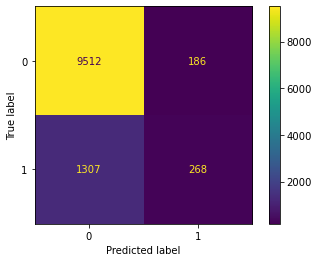

In [42]:
plot_confusion_matrix(lr, xval, yval)

### lazypredict

In [43]:
# Lazy Predict is a great tool to easily test your dataset across over thirty models
# this gives us a head start in our modelling as we can begin experimenting with the highest scorer below
def model_lazy(xtrain, ytrain):
    clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
    models, predictions = clf.fit(xtrain, xval, ytrain, yval)

    print(models)

In [54]:
model_lazy(xtrain, ytrain)

100%|██████████| 29/29 [17:54<00:00, 37.03s/it] 

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
DecisionTreeClassifier             0.91               0.82     0.82      0.91   
RandomForestClassifier             0.93               0.82     0.82      0.93   
ExtraTreesClassifier               0.93               0.82     0.82      0.92   
ExtraTreeClassifier                0.91               0.81     0.81      0.91   
BaggingClassifier                  0.92               0.81     0.81      0.92   
LabelPropagation                   0.91               0.79     0.79      0.91   
NearestCentroid                    0.76               0.72     0.72      0.79   
KNeighborsClassifier               0.88               0.67     0.67      0.86   
XGBClassifier                      0.88               0.65     0.65      0.87   
LGBMClassifier                     0.88               0.64     0.64      0.86   
LinearDiscriminantAnalysis  

In [ ]:
model_lazy(xtrain_smote, ytrain_smote)

 38%|███▊      | 11/29 [06:35<18:37, 62.10s/it]

In [ ]:
model_lazy(xtrain_adasyn, ytrain_adasyn)

In [ ]:
model_lazy(xtrain_ovr, ytrain_ovr)

In [ ]:
model_lazy(xtrain_und, ytrain_und)

### Random Forest

In [45]:
# since Random Forests generated the best results, we should try and improve upon it
def randomforest(xtrain, ytrain, xval, yval):
    rfc = RandomForestClassifier()
    rfc.fit(xtrain, ytrain)
    ypred = rfc.predict(xval)
    plot_confusion_matrix(estimator=rfc, y_true=yval, X = xval)

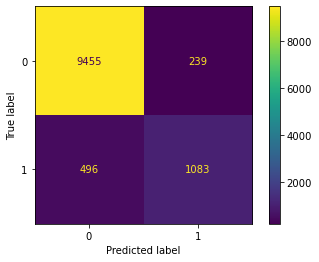

In [46]:
# No Sampling
randomforest(xtrain, ytrain, xval, yval)

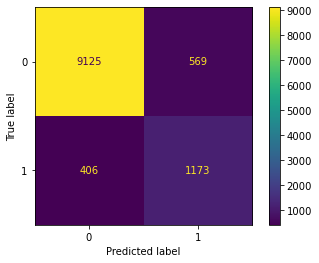

In [47]:
# Sampling w/ SMOTE
randomforest(xtrain_smote, ytrain_smote, xval, yval)

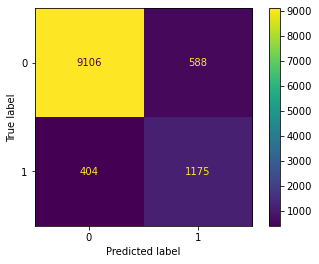

In [48]:
# Sampling with ADASYN
randomforest(xtrain_adasyn, ytrain_adasyn, xval, yval)

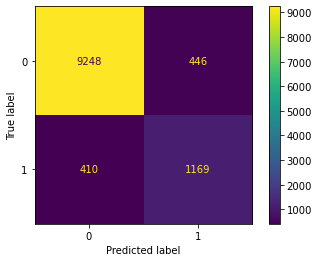

In [49]:
# Basic Oversampling provides our best result out of the four
randomforest(xtrain_ovr, ytrain_ovr, xval, yval)

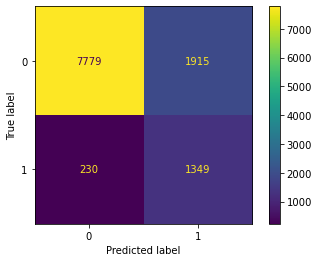

In [50]:
# Basic Undersampling
randomforest(xtrain_und, ytrain_und, xval, yval)

### Random Forest w/ Bayesian Optimization

In [38]:
# lets cross validate over the ADASYN sampling train set to tune the parameters
from sklearn.model_selection import RandomizedSearchCV

In [39]:
def rf_cv(X, y, **kwargs):
    estimator = RandomForestClassifier(**kwargs)
    cval = cross_val_score(estimator, X, y, scoring = 'roc_auc', cv = 4, verbose = 3, n_jobs = -1)
    return cval.mean()

In [40]:
def bayes_opt_rf(X, y, n_iter = 100):
    def rf_cval(n_estimators, max_features, max_depth, min_samples_split, min_samples_leaf):
        return rf_cv(
            X = X,
            y = y,
            class_weight = "balanced",
            criterion = "entropy",
            min_samples_leaf = round(min_samples_leaf),
            min_samples_split = round(min_samples_split),
            max_depth = round(max_depth),
            n_estimators = round(n_estimators),
            max_features = max(min(max_features, 0.999), 1e-3),
            bootstrap = True
        )
    
    optimizer = BayesianOptimization(
        f = rf_cval,
        pbounds = {
            'max_depth': (5, 40),
            'min_samples_split': (1, 40),
            'min_samples_leaf': (1, 40),
            "n_estimators" : (10, 500),
            "max_features" : (0.1, 0.999),
        }
    )
    optimizer.maximize(n_iter = n_iter, init_points=10)
    print("Final result:", optimizer.max)

In [ ]:
bayes_opt_rf(xtrain, ytrain, n_iter = 4)

In [40]:
def optim_rf(xtrain, ytrain, yval, xval):
    optimized_model = RandomForestClassifier(n_estimators = 135,
                                             max_depth= 34.12,
                                             max_features= 0.8473,
                                             min_samples_leaf= 1,
                                             min_samples_split= 2,
                                             random_state=888)
    optimized_model.fit(xtrain, ytrain)
    plot_confusion_matrix(estimator=optimized_model, y_true=yval, X = xval)

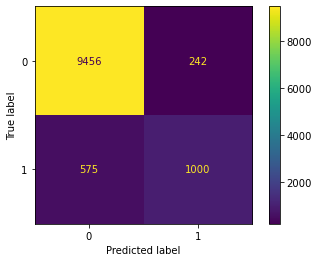

In [50]:
optim_rf(xtrain, ytrain, yval, xval)

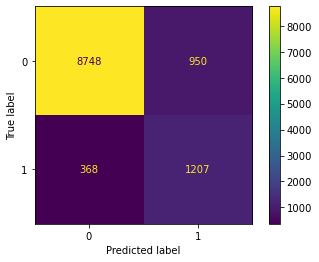

In [51]:
optim_rf(xtrain_smote, ytrain_smote, yval, xval)

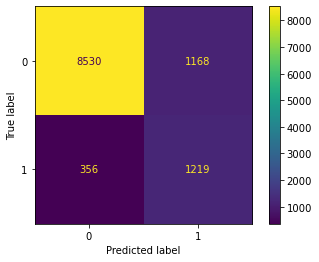

In [52]:
optim_rf(xtrain_adasyn, ytrain_adasyn, yval, xval)

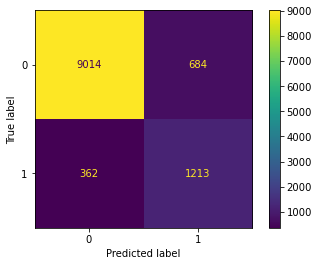

In [53]:
optim_rf(xtrain_ovr, ytrain_ovr, yval, xval) #Best Model So Far

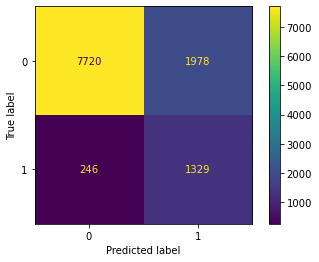

In [54]:
optim_rf(xtrain_und, ytrain_und, yval, xval)

In [42]:
bayes_opt_rf(xtrain_ovr, ytrain_ovr, n_iter = 4)

|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   39.3s finished


|  1        |  0.8716   |  21.61    |  0.9474   |  38.72    |  26.14    |  45.78    |


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  4.4min finished


|  2        |  0.8755   |  34.6     |  0.8121   |  38.9     |  8.52     |  346.1    |


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  4.8min finished


|  3        |  0.9287   |  21.88    |  0.8804   |  10.76    |  2.049    |  316.9    |


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  5.4min finished


|  4        |  0.9134   |  20.67    |  0.9965   |  14.08    |  38.78    |  325.2    |


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


|  5        |  0.8432   |  10.84    |  0.2075   |  14.98    |  32.47    |  369.3    |


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  1.8min finished


|  6        |  0.8697   |  25.32    |  0.285    |  29.92    |  23.65    |  293.1    |


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  2.5min finished


|  7        |  0.9409   |  29.87    |  0.6736   |  10.18    |  24.84    |  167.4    |


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  3.5min finished


|  8        |  0.8832   |  32.57    |  0.6468   |  31.76    |  22.19    |  316.1    |


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  1.6min finished


|  9        |  0.8286   |  8.312    |  0.6921   |  9.436    |  2.31     |  274.0    |


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  3.8min finished


|  10       |  0.8312   |  9.493    |  0.8303   |  32.48    |  28.24    |  484.8    |


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  2.9min finished


|  11       |  0.9445   |  26.66    |  0.9887   |  8.571    |  24.14    |  167.2    |


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  2.4min finished


|  12       |  0.9634   |  22.7     |  0.9268   |  2.627    |  12.44    |  143.0    |


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   38.1s finished


|  13       |  0.7962   |  5.0      |  0.9337   |  1.0      |  40.0     |  136.0    |


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  2.9min finished


|  14       |  0.9724   |  29.69    |  0.999    |  4.693    |  4.643    |  156.9    |
Final result: {'target': 0.9723893773146411, 'params': {'max_depth': 29.690834380807978, 'max_features': 0.999, 'min_samples_leaf': 4.693426468809283, 'min_samples_split': 4.64282058470091, 'n_estimators': 156.85483083427172}}


In [47]:
def optim_rf_ovr(xtrain, ytrain, yval, xval):
    optimized_model = RandomForestClassifier(n_estimators = 157,
                                             max_depth= 29.690834380807978,
                                             max_features= 0.999,
                                             min_samples_leaf= 5,
                                             min_samples_split= 5,
                                             random_state=888)
    optimized_model.fit(xtrain, ytrain)
    plot_confusion_matrix(estimator=optimized_model, y_true=yval, X = xval)

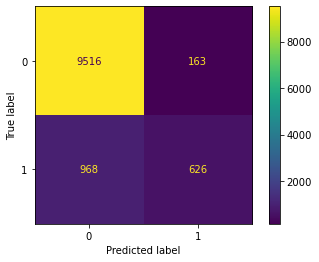

In [48]:
optim_rf_ovr(xtrain, ytrain, yval, xval)

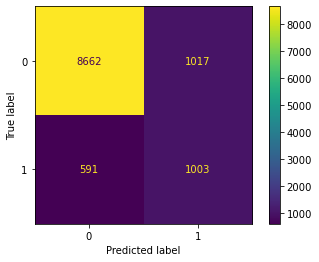

In [49]:
optim_rf_ovr(xtrain_smote, ytrain_smote, yval, xval)

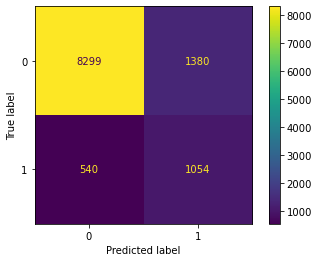

In [50]:
optim_rf_ovr(xtrain_adasyn, ytrain_adasyn, yval, xval)

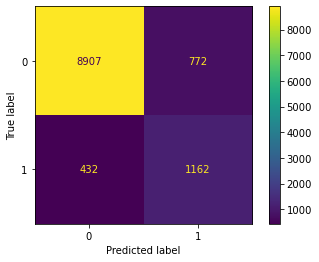

In [51]:
optim_rf_ovr(xtrain_ovr, ytrain_ovr, yval, xval)

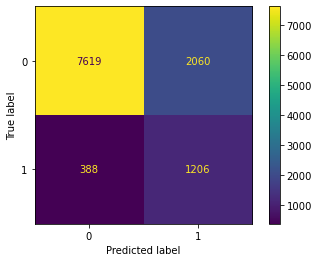

In [52]:
optim_rf_ovr(xtrain_und, ytrain_und, yval, xval)

In [ ]:
# None of these models are an improvement over the models not optimized with sampled data

### XGBoost

In [53]:
import xgboost as xgb
df = df.astype(int)

In [54]:
# XGBoost requires it own matrix type to be used
# XGBoost was built with sparse data in mind, adding the missing paramater will greatly improve the efficiency of the training
dtrain = xgb.DMatrix(xtrain, label=ytrain, missing=0)
dtest  = xgb.DMatrix(xtest, label=ytest, missing=0)
dval   = xgb.DMatrix(xval, label=yval, missing=0)

In [ ]:
# lets define a parameter tuner using Bayesian Optimiization again
def bo_tune_xgb(max_depth, gamma ,learning_rate, scale_pos_weight, min_child_weight, colsample_bytree, subsample, alpha, lambd):
    params = {'max_depth'       : int(max_depth),
              'gamma'           : gamma,
#               'n_estimators'    : int(n_estimators),
              'learning_rate'   : learning_rate,
              'alpha'           : alpha,
              'lambda'          : lambd,
              'subsample'       : subsample,
              'eval_metric'     : 'rmse',
              'min_child_weight': min_child_weight,
              'scale_pos_weight': scale_pos_weight,
              'colsample_bytree': colsample_bytree,
              'tree_method'     : 'gpu_hist'}
    cv_result = xgb.cv(params, dtrain, num_boost_round=200, nfold=5)
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

In [ ]:
# here we define the ranges that Bayesian Optimization is allowed to search through
# these ranges are common parameter ranges that most models fall into
xgb_bo = BayesianOptimization(bo_tune_xgb, {'max_depth' : (1, 20),
                        'gamma'            : (0, 2),
                        'alpha'            : (0, 10),
                        'lambd'           : (0,3),
                        'subsample'        : (0,1),           
                        'learning_rate'    : (0,2),
#                         'n_estimators'     : (100,400),
                        'scale_pos_weight' : (6,7),
                        'min_child_weight' : (1,10),
                        'colsample_bytree' : (0,1)} ,verbose=3)

In [ ]:
# here we search for the strongest parameter combination
xgb_bo.maximize(n_iter=7, init_points=5, acq='ei')

In [ ]:
# .max returns the strongest parameters
params = xgb_bo.max['params']

# some of the parameters need to be whole numbers
params['max_depth'] = int(params['max_depth'])
# params['n_estimators'] = int(params['n_estimators'])
params

In [ ]:
# lets see our results for the train data
xgb_opt= xgb.train(params, dtrain)
predsopt = xgb_opt.predict(dtrain)
print(classification_report(predsopt.round(), ytrain))

In [ ]:
confusion_matrix(predsopt.round(), ytrain)

In [ ]:
# and now for the validation
predsoptval = xgb_opt.predict(dval)
print(classification_report(predsoptval.round(), yval))

In [ ]:
confusion_matrix(predsoptval.round(), yval)

In [ ]:
predsoptval = xgb_opt.predict(dval)
print(classification_report(predsoptval.round(), yval))

### Neural Network

# Flask App

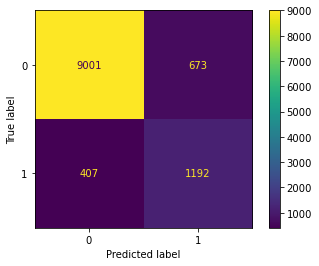

In [43]:
optimized_model = RandomForestClassifier(n_estimators = 135,
                                             max_depth= 34.12,
                                             max_features= 0.8473,
                                             min_samples_leaf= 1,
                                             min_samples_split= 2,
                                             random_state=888)
optimized_model.fit(xtrain_ovr, ytrain_ovr)
plot_confusion_matrix(estimator=optimized_model, y_true=yval, X = xval)

In [44]:
import pickle
filename='model.pkl'
pickle.dump(optimized_model, open('model.pkl', 'wb'))

In [45]:
model = pickle.load(open('model.pkl','rb'))
print(model.predict([[4, 300, 500]]))

ValueError: X has 3 features, but DecisionTreeClassifier is expecting 231 features as input.

In [46]:
xtrain

,AGE_YRS,SEX,DISABLE,BIRTH_DEFECT,VAX_DOSE_SERIES,none cur_ill,nka,nkda,penicillin,sulfa,pcn,latex,codeine,amoxicillin,sulfa drugs,shellfish,morphine,bactrim,seasonal allergies cur_ill,erythromycin,aspirin,sulfa antibiotics,augmentin,lisinopril meds,lactose,denies,penicillins,bee stings,iodine,nickel,cipro,ceclor,levaquin,seasonal,compazine,percocet,gluten,nkma,doxycycline,nsaids,keflex,ibuprofen meds,naproxen,tree nuts,bee venom,codiene,peanuts,clindamycin,none history,covid-19 history,asthma history,uti,seasonal allergies history,sinus infection,hypertension history,diabetes history,migraines history,blood pressure high,migraine history,urinary tract infection,hypothyroidism history,allergies,anxiety history,diabetic,gerd history,acid reflux,sinusitis,cold,copd history,new diagnosis of t2dm,rheumatoid arthritis history,fibromyalgia history,none meds,asthma,hypertension,hypothyroidism,diabetes,high blood pressure,migraines,htn,covid-19,anxiety,gerd,obesity,depression,hypothyroid,arthritis,rheumatoid arthritis,high cholesterol,copd,seasonal allergies,penicillin allergy,fibromyalgia,migraine,pcos,hyperlipidemia,lupus,sulfonamide allergy,ibs,ulcerative colitis,psoriasis,adhd,none,multivitamin,tylenol,synthroid,levothyroxine,birth control,ibuprofen,vitamin d,lexapro,prenatal vitamins,zyrtec,adderall,zoloft,vitamins,lisinopril,metformin,prenatal vitamin,multivitamins,multi vitamin,losartan,prozac,flonase,wellbutrin,eliquis,metoprolol,nuvaring,vitamin c,atorvastatin,omeprazole,multi-vitamin,insulin,melatonin,birth control pill,daily multivitamin,mirena iud,acetaminophen,amlodipine,prilosec,sertraline,vitamin d3,albuterol,birth control pills,coumadin,benadryl,allegra,STATE: _0,STATE: _1,STATE: _2,STATE: _3,STATE: _4,STATE: _5,STATE: _6,STATE: _7,STATE: _8,STATE: _9,STATE: _10,STATE: _11,STATE: _12,STATE: _13,STATE: _14,STATE: _15,STATE: _16,STATE: _17,STATE: _18,STATE: _19,STATE: _20,STATE: _21,STATE: _22,STATE: _23,STATE: _24,STATE: _25,STATE: _26,STATE: _27,STATE: _28,STATE: _29,STATE: _30,STATE: _31,STATE: _32,STATE: _33,STATE: _34,STATE: _35,STATE: _36,STATE: _37,STATE: _38,STATE: _39,STATE: _40,STATE: _41,STATE: _42,STATE: _43,STATE: _44,STATE: _45,STATE: _46,STATE: _47,STATE: _48,STATE: _49,STATE: _50,STATE: _51,STATE: _52,STATE: _53,BRAND: _0,BRAND: _1,BRAND: _2,BRAND: _3,VAX_SITE: _0,VAX_SITE: _1,VAX_SITE: _2,VAX_SITE: _3,VAX_SITE: _4,VAX_SITE: _5,VAX_SITE: _6,VAX_SITE: _7,VAX_SITE: _8,VAX_SITE: _9,VAX_ROUTE: _0,VAX_ROUTE: _1,VAX_ROUTE: _2,VAX_ROUTE: _3,VAX_ROUTE: _4,VAX_ROUTE: _5,VAX_ROUTE: _6,ADMINBY: _0,ADMINBY: _1,ADMINBY: _2,ADMINBY: _3,ADMINBY: _4,ADMINBY: _5,ADMINBY: _6,ADMINBY: _7,ADMINBY: _8
42473,24,1,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
53550,51,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2526,36,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,